# Introduccion

Objetivo: predecir y explicar niveles de estrés en estudiantes.

Variables:
1) Timestamp (object → fecha/hora)
2) Your Academic Stage (object → categórica ordinal): Nivel actual de estudios
3) Peer pressure (int → Likert/ordinal): Nivel de presion de pares (companeros)
4) Academic pressure from your home (int → Likert/ordinal): Presion academica percibida desde el hogar
5) Study Environment (object → categórica): Calidad del entorno de estudio
6) What coping strategy you use as a student? (object → categórica / multi-etiqueta): Estrategias de afrontamiento
7) Do you have any bad habits like smoking, drinking on a daily basis? (object → binaria): Malos habitos
8) What would you rate the academic competition in your student life (int → Likert/ordinal): Percepcion de competencia academica (rating)
9) Rate your academic stress index (int → objetivo): Indice de estres academico

Preguntas:


¿Qué factores conductuales/ambientales disparan el estrés?

¿Podemos predecir estrés (regresión/ clasificación)?

¿Existen perfiles de estrés (clustering) útiles para intervenciones?

Impacto: lineamientos para bienestar estudiantiles.

# 1 - Dataset - importar y normalizar

In [1]:
import kagglehub
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV, KFold,StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import  RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, precision_recall_fscore_support, roc_auc_score, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, classification_report, confusion_matrix, precision_score, recall_score, roc_curve, precision_recall_curve)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [2]:

path = kagglehub.dataset_download("poushal02/student-academic-stress-real-world-dataset")

print("Path to dataset files:", path)
os.listdir(path)

Path to dataset files: /kaggle/input/student-academic-stress-real-world-dataset


['academic Stress level - maintainance 1.csv']

In [3]:
df=pd.read_csv(path+"/academic Stress level - maintainance 1.csv")
df.head()

,Timestamp,Your Academic Stage,Peer pressure,Academic pressure from your home,Study Environment,What coping strategy you use as a student?,"Do you have any bad habits like smoking, drinking on a daily basis?",What would you rate the academic competition in your student life,Rate your academic stress index
0,24/07/2025 22:05:39,undergraduate,4,5,Noisy,Analyze the situation and handle it with intel...,No,3,5
1,24/07/2025 22:05:52,undergraduate,3,4,Peaceful,Analyze the situation and handle it with intel...,No,3,3
2,24/07/2025 22:06:39,undergraduate,1,1,Peaceful,"Social support (friends, family)",No,2,4
3,24/07/2025 22:06:45,undergraduate,3,2,Peaceful,Analyze the situation and handle it with intel...,No,4,3
4,24/07/2025 22:08:06,undergraduate,3,3,Peaceful,Analyze the situation and handle it with intel...,No,4,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 9 columns):
 #   Column                                                               Non-Null Count  Dtype 
---  ------                                                               --------------  ----- 
 0   Timestamp                                                            140 non-null    object
 1   Your Academic Stage                                                  140 non-null    object
 2   Peer pressure                                                        140 non-null    int64 
 3   Academic pressure from your home                                     140 non-null    int64 
 4   Study Environment                                                    139 non-null    object
 5   What coping strategy you use as a student?                           140 non-null    object
 6   Do you have any bad habits like smoking, drinking on a daily basis?  140 non-null    object
 7   What would you rat

In [5]:
for c in df.select_dtypes("object"):
    print(c, "→", df[c].dropna().unique()[:10])

Timestamp → ['24/07/2025 22:05:39' '24/07/2025 22:05:52' '24/07/2025 22:06:39'
 '24/07/2025 22:06:45' '24/07/2025 22:08:06' '24/07/2025 22:08:13'
 '24/07/2025 22:09:21' '24/07/2025 22:10:06' '24/07/2025 22:11:01'
 '24/07/2025 22:11:19']
Your Academic Stage → ['undergraduate' 'high school' 'post-graduate']
Study Environment → ['Noisy' 'Peaceful' 'disrupted']
What coping strategy you use as a student? → ['Analyze the situation and handle it with intellect'
 'Social support (friends, family)' 'Emotional breakdown (crying a lot)']
Do you have any bad habits like smoking, drinking on a daily basis? → ['No' 'prefer not to say' 'Yes']


In [6]:
df = df.copy()  # para trabajar sobre esta copia
df.columns = (pd.Index(df.columns)
              .str.normalize('NFKC')              # normaliza caracteres raros
              .str.replace(r'\s+', ' ', regex=True)  # convierte espacios dobles -> simple
              .str.strip())                        # quita espacios al inicio/fin
print(list(map(repr, df.columns)))

["'Timestamp'", "'Your Academic Stage'", "'Peer pressure'", "'Academic pressure from your home'", "'Study Environment'", "'What coping strategy you use as a student?'", "'Do you have any bad habits like smoking, drinking on a daily basis?'", "'What would you rate the academic competition in your student life'", "'Rate your academic stress index'"]


In [7]:
df.columns = df.columns.str.replace(' ', '_', regex=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 9 columns):
 #   Column                                                               Non-Null Count  Dtype 
---  ------                                                               --------------  ----- 
 0   Timestamp                                                            140 non-null    object
 1   Your_Academic_Stage                                                  140 non-null    object
 2   Peer_pressure                                                        140 non-null    int64 
 3   Academic_pressure_from_your_home                                     140 non-null    int64 
 4   Study_Environment                                                    139 non-null    object
 5   What_coping_strategy_you_use_as_a_student?                           140 non-null    object
 6   Do_you_have_any_bad_habits_like_smoking,_drinking_on_a_daily_basis?  140 non-null    object
 7   What_would_you_rat

In [8]:
df = df.drop(columns=['Timestamp'])

In [9]:
moda = df["Study_Environment"].mode()[0]
df["Study_Environment"].fillna(moda, inplace=True)

/tmp/ipython-input-633380357.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Study_Environment"].fillna(moda, inplace=True)


# 2 - EDA

A - Histogramas

array([[<Axes: title={'center': 'Peer_pressure'}>,
        <Axes: title={'center': 'Academic_pressure_from_your_home'}>],
       [<Axes: title={'center': 'What_would_you_rate_the_academic_competition_in_your_student_life'}>,
        <Axes: title={'center': 'Rate_your_academic_stress_index'}>]],
      dtype=object)

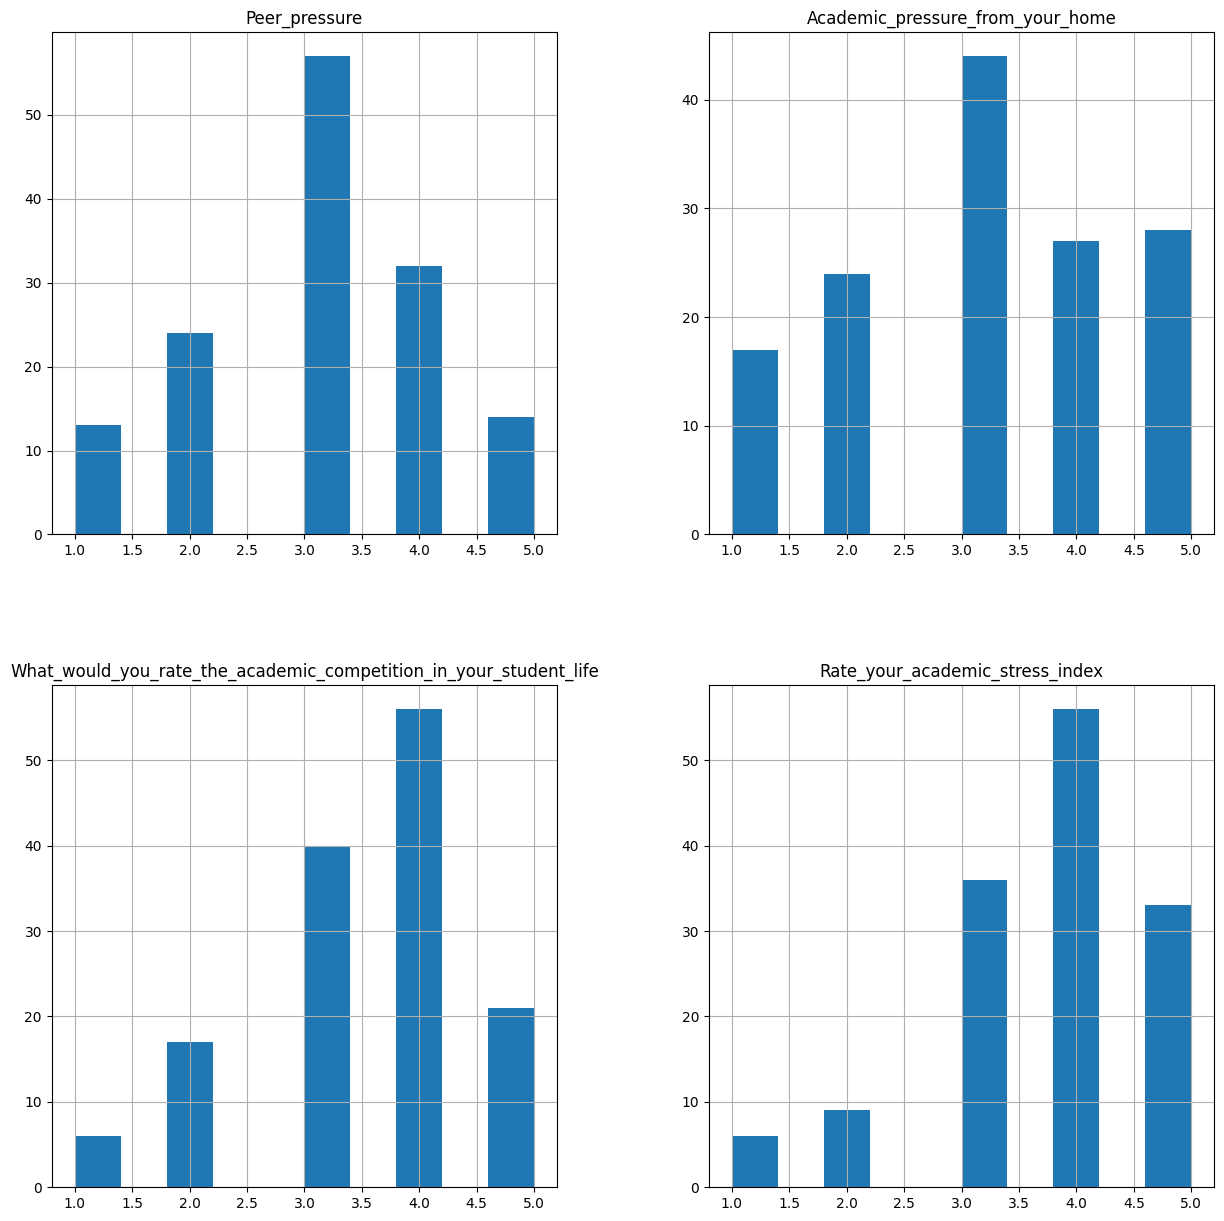

In [10]:
df.hist(figsize=(15,15))

B - Matriz de correlacion

/tmp/ipython-input-1566922192.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.title("Spearman (numéricas)"); plt.tight_layout(); plt.show()


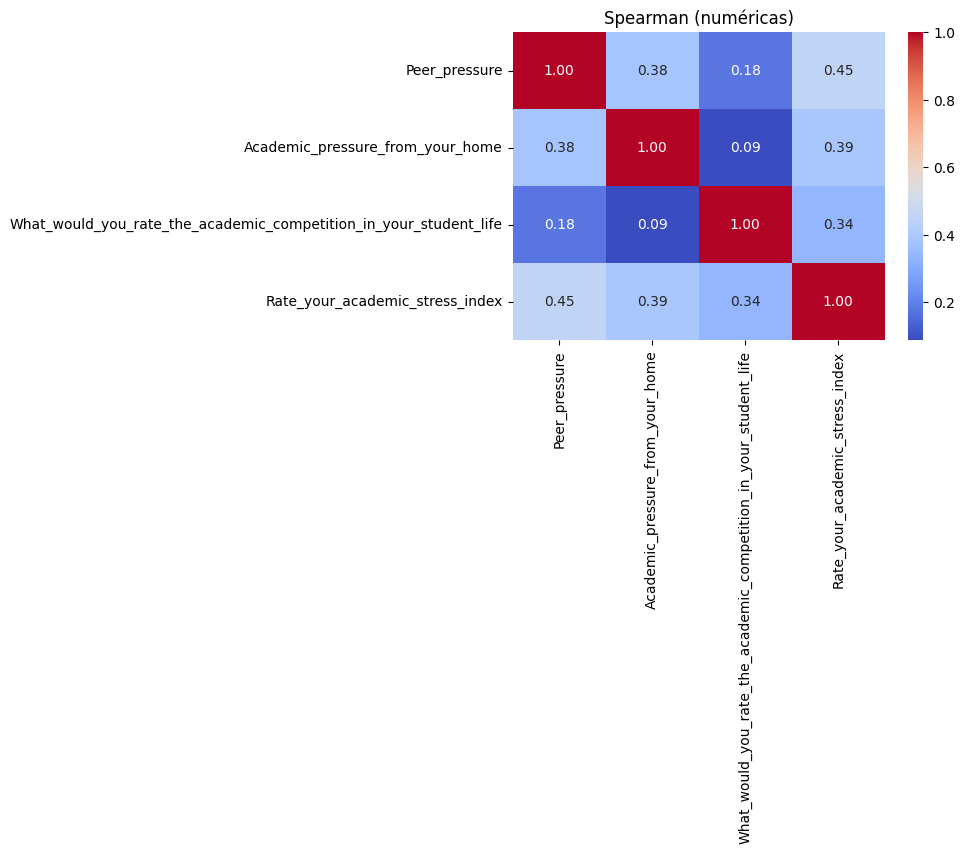

In [11]:

num_cols = [c for c in [
    "Peer_pressure",
    "Academic_pressure_from_your_home",
    "What_would_you_rate_the_academic_competition_in_your_student_life",
    "Rate_your_academic_stress_index",
] if c in df.columns]

# Heatmap
corr = df[num_cols].corr(method="spearman")
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Spearman (numéricas)"); plt.tight_layout(); plt.show()


C - BOXPLOT estres por entorno y por etapa academica

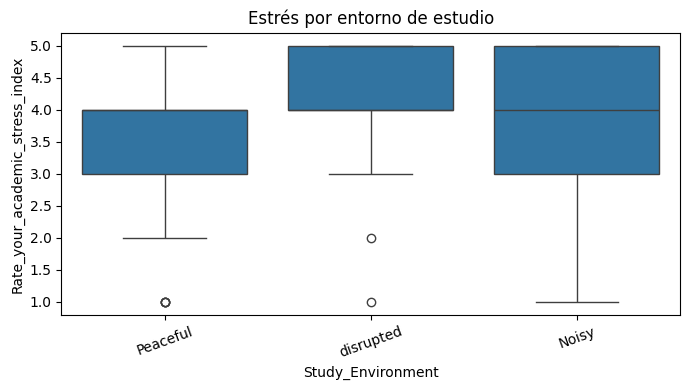

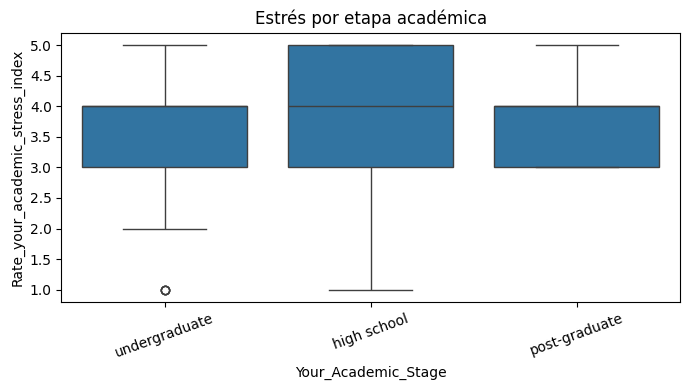

In [12]:
env, stage = "Study_Environment", "Your_Academic_Stage"
y='Rate_your_academic_stress_index'

if env in df.columns:
    order_env = df[env].value_counts().index
    plt.figure(figsize=(7,4))
    sns.boxplot(x=env, y=y, data=df, order=order_env)
    plt.title("Estrés por entorno de estudio"); plt.xticks(rotation=20); plt.tight_layout(); plt.show()

if stage in df.columns:
    order_stage = df[stage].value_counts().index
    plt.figure(figsize=(7,4))
    sns.boxplot(x=stage, y=y, data=df, order=order_stage)
    plt.title("Estrés por etapa académica"); plt.xticks(rotation=20); plt.tight_layout(); plt.show()

D - Heatmap estres por entorno y etapa academica usando promedios

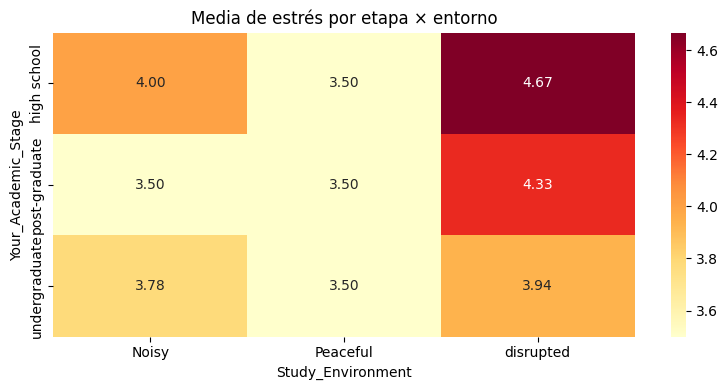

In [13]:
if env in df.columns and stage in df.columns:
    pt = df.pivot_table(index=stage, columns=env, values=y, aggfunc="mean")
    plt.figure(figsize=(8,4))
    sns.heatmap(pt, annot=True, fmt=".2f", cmap="YlOrRd")
    plt.title("Media de estrés por etapa × entorno")
    plt.tight_layout(); plt.show()

E - Relaciones lineales con la variable target

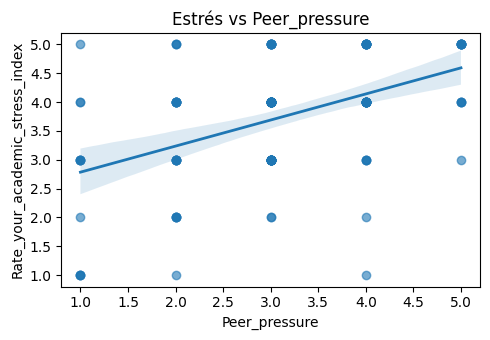

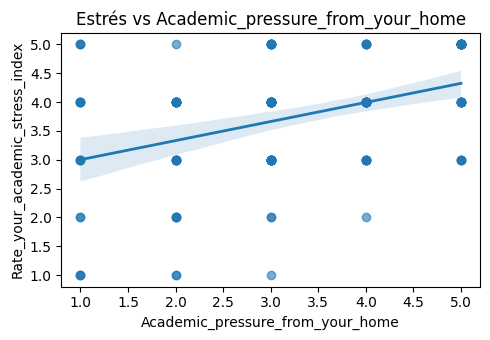

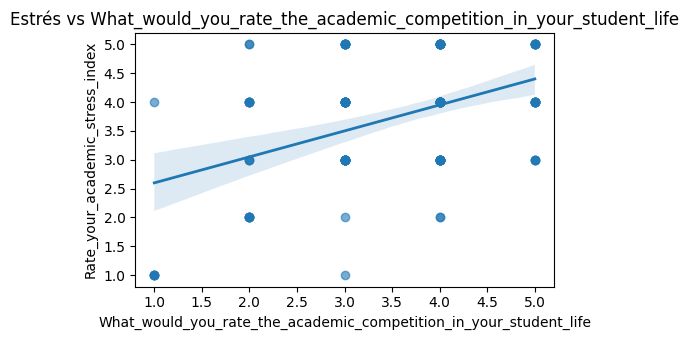

In [14]:
for c in [col for col in num_cols if col != y]:
    plt.figure(figsize=(5,3.5))
    sns.regplot(x=c, y=y, data=df, scatter_kws={"alpha":0.6}, line_kws={"lw":2})
    plt.title(f"Estrés vs {c}"); plt.tight_layout(); plt.show()

E - Estres promedio por estrategia

/tmp/ipython-input-4009509776.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x=col, y=y, data=df, order=order, ci=95)  # IC del 95%


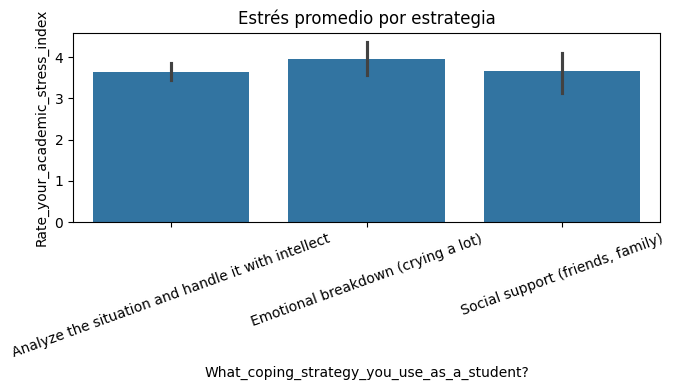

In [15]:
col = "What_coping_strategy_you_use_as_a_student?"
y   = "Rate_your_academic_stress_index"

order = df[col].value_counts().index
plt.figure(figsize=(7,4))
sns.barplot(x=col, y=y, data=df, order=order, ci=95)  # IC del 95%
plt.title("Estrés promedio por estrategia")
plt.xticks(rotation=20); plt.tight_layout(); plt.show()

F - Estres promedio por habitos

/tmp/ipython-input-3172029570.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x=col, y=y, data=df, order=order, ci=95)  # IC del 95%


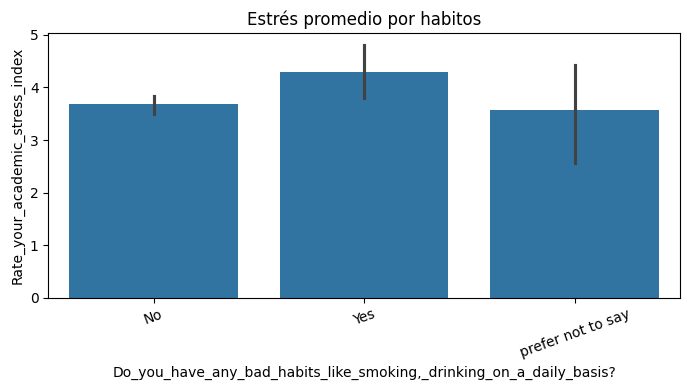

In [16]:
col = "Do_you_have_any_bad_habits_like_smoking,_drinking_on_a_daily_basis?"
y   = "Rate_your_academic_stress_index"

order = df[col].value_counts().index
plt.figure(figsize=(7,4))
sns.barplot(x=col, y=y, data=df, order=order, ci=95)  # IC del 95%
plt.title("Estrés promedio por habitos")
plt.xticks(rotation=20); plt.tight_layout(); plt.show()

G - Conclusion

Se vio que la presión de pares, la presion académica desde el hogar y la competencia correlacionaban positivamente con el índice de estrés.

El entorno de estudio también marcaba diferencias: estudiantes en entornos “disrupted” o “noisy” reportaban más estrés.

Las estrategias de afrontamiento mostraban impacto: quienes usaban apoyo social tenían, en promedio, menor nivel de estrés que quienes tendían a crisis emocionales

Esta fase permitió identificar que había clases desbalanceadas (muchos estudiantes con estrés alto, pocos con bajo), algo importante para el modelado.

# 3 - Modelado supervisado - Regresion del indice de estres

3.1 Considerando escala 1-5

In [17]:
df['Rate_your_academic_stress_index'].unique()

array([5, 3, 4, 2, 1])

A- Conjunto de modelado y preprocesamiento

In [18]:
y_R='Rate_your_academic_stress_index'
X_R=df.drop(columns=[y_R],errors='ignore')
y_R=df[y_R]
print("X_R shape:", X_R.shape)        # filas x columnas (predictores)
print("y_R shape:", y_R.shape)        # filas (target)
print("X_R cols:", list(X_R.columns))

X_R shape: (140, 7)
y_R shape: (140,)
X_R cols: ['Your_Academic_Stage', 'Peer_pressure', 'Academic_pressure_from_your_home', 'Study_Environment', 'What_coping_strategy_you_use_as_a_student?', 'Do_you_have_any_bad_habits_like_smoking,_drinking_on_a_daily_basis?', 'What_would_you_rate_the_academic_competition_in_your_student_life']


In [19]:

X_R = pd.get_dummies(X_R, drop_first=True)

X_R_train, X_R_test, y_R_train, y_R_test = train_test_split(
    X_R, y_R, test_size=0.2, random_state=42
)

B- Pipeline y Gridsearch

In [20]:

pipe_R = Pipeline([
    ("scaler", MinMaxScaler()),   # escala todo 0..1
    ("clf", LinearRegression())   # placeholder: el grid lo cambia a RF cuando toque
])


param_grid_R = [
    {
        "clf": [LinearRegression()],
        "clf__fit_intercept": [True, False],

    },
    {
        "clf": [RandomForestRegressor(random_state=42, n_jobs=-1)],
        "clf__n_estimators": [300, 600],
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_leaf": [1, 3, 5],
        "clf__max_features": ["sqrt", "log2", 0.8],
    }
]

cv_R = KFold(n_splits=5, shuffle=True, random_state=42)

In [21]:
gs_R = GridSearchCV(
    pipe_R, param_grid_R,
    cv=cv_R,
    scoring="neg_root_mean_squared_error",  # optimiza RMSE
    n_jobs=-1, refit=True, verbose=0
)
gs_R.fit(X_R_train, y_R_train)

print("Mejor modelo:", gs_R.best_estimator_.named_steps["clf"].__class__.__name__)
print("Mejores params:", gs_R.best_params_)
print("CV RMSE:", round(-gs_R.best_score_, 3))

Mejor modelo: LinearRegression
Mejores params: {'clf': LinearRegression(), 'clf__fit_intercept': True}
CV RMSE: 0.834


C- Evaluacion de modelo

In [22]:

y_pred_R = gs_R.best_estimator_.predict(X_R_test)
rmse_R = np.sqrt(mean_squared_error(y_R_test, y_pred_R))
mae_R  = mean_absolute_error(y_R_test, y_pred_R)
r2_R   = r2_score(y_R_test, y_pred_R)
print(f"Test → RMSE: {rmse_R:.3f} | MAE: {mae_R:.3f} | R²: {r2_R:.3f}")

Test → RMSE: 0.793 | MAE: 0.697 | R²: 0.340


D - Graficos

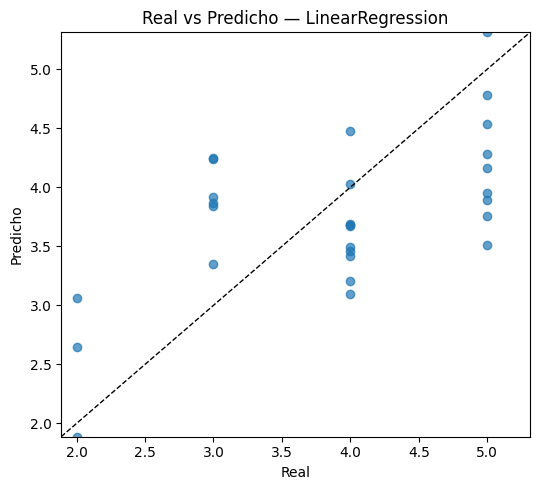

In [23]:

plt.figure(figsize=(5.5,5))
plt.scatter(y_R_test, y_pred_R, alpha=0.7)
lims = [min(y_R_test.min(), y_pred_R.min()), max(y_R_test.max(), y_pred_R.max())]
plt.plot(lims, lims, "k--", lw=1)
plt.xlim(lims); plt.ylim(lims)
plt.xlabel("Real"); plt.ylabel("Predicho")
plt.title(f"Real vs Predicho — {gs_R.best_estimator_.named_steps['clf'].__class__.__name__}")
plt.tight_layout(); plt.show()

E- Reduccion de error

In [24]:
#Baseline - error reducido un 22%

In [25]:
y_mean = np.repeat(y_R_train.mean(), len(y_R_test))
print("Baseline RMSE:", np.sqrt(mean_squared_error(y_R_test, y_mean)))
print("Baseline MAE :", mean_absolute_error(y_R_test, y_mean))
print("Baseline R2  :", r2_score(y_R_test, y_mean))

Baseline RMSE: 0.9993620414023731
Baseline MAE : 0.8647959183673473
Baseline R2  : -0.048192771084337505


F- Variables mas influyentes

In [26]:


from sklearn.inspection import permutation_importance


pi = permutation_importance(
    gs_R.best_estimator_, X_R_test, y_R_test,
    n_repeats=30, scoring="neg_mean_squared_error", random_state=42
)
imp = pd.Series(pi.importances_mean, index=X_R_test.columns).sort_values(ascending=False)
imp.head(10)

,0
What_would_you_rate_the_academic_competition_in_your_student_life,0.295819
Peer_pressure,0.165150
Academic_pressure_from_your_home,0.058604
Study_Environment_disrupted,0.011892
Your_Academic_Stage_undergraduate,0.004139
Your_Academic_Stage_post-graduate,0.000067
"Do_you_have_any_bad_habits_like_smoking,_drinking_on_a_daily_basis?_Yes",-0.003396
"Do_you_have_any_bad_habits_like_smoking,_drinking_on_a_daily_basis?_prefer not to say",-0.003910
What_coping_strategy_you_use_as_a_student?_Emotional breakdown (crying a lot),-0.024060
"What_coping_strategy_you_use_as_a_student?_Social support (friends, family)",-0.027420


G- Conclusiones de la regresion

Se probó con Linear Regression y Random Forest Regressor, usando GridSearch y validación cruzada.

El mejor modelo fue la regresión lineal, con RMSE ≈ 0.78 y R² ≈ 0.36


Aunque el poder predictivo fue moderado, se redujo un 22% el error frente a un baseline.

Las variables más influyentes fueron la percepción de competencia académica y presión de pares.

# 4 - Clasificacion del nivel de estres

4.1 Clasificacion multiclase, low - mid - high

A- Conjunto de modelado y preprocesamiento

In [27]:
y_C_3 = df["Rate_your_academic_stress_index"].astype(float)


# Validación: debe ser escala 1–5
if not y_C_3.dropna().between(1, 5).all():
    raise ValueError("El target debe estar en la escala 1–5 para esta discretización.")

# Discretización: bajo=[1–2], medio=[3], alto=[4–5]
bins   = [0, 2, 3, 5]
labels = ["low", "mid", "high"]

y_C_3 = pd.cut(
    y_C_3,
    bins=bins,
    labels=labels,
    include_lowest=True,   # incluye el 1 en 'low'
    right=True             # intervalos (0,2], (2,3], (3,5]
).astype("category")

# Orden explícito de las categorías
y_C_3 = y_C_3.cat.set_categories(labels, ordered=True)

print("Distribución de clases:\n", y_C_3.value_counts())

Distribución de clases:
 Rate_your_academic_stress_index
high    89
mid     36
low     15
Name: count, dtype: int64


In [28]:
# --- 2) X con dummies (simple) ---
X_C_3 = df.drop(columns=["Rate_your_academic_stress_index"])
X_C_3 = pd.get_dummies(X_C_3, drop_first=True)

# --- 3) Split estratificado ---
X_C_3_train, X_C_3_test, y_C_3_train, y_C_3_test = train_test_split(
    X_C_3, y_C_3, test_size=0.2, random_state=42, stratify=y_C_3)

B- Pipeline y Gridsearch

In [29]:

pipe_C_3 = Pipeline([
    ("scaler", MinMaxScaler()),
    ("clf", LogisticRegression(random_state=42, max_iter=1000))
])

param_grid_C_3 = [
    {   # Logistic Regression
        "clf": [LogisticRegression(random_state=42,max_iter=1000)],
        "clf__C": [0.1, 1, 10],
        "clf__class_weight": [None, "balanced"],
        "clf__solver": ["lbfgs"]
    },
    {   # Random Forest
        "clf": [RandomForestClassifier(random_state=42, n_jobs=-1)],
        "clf__n_estimators": [300, 600],
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_leaf": [1, 3, 5],
        "clf__max_features": ["sqrt", "log2", 0.8],
        "clf__class_weight": [None, "balanced"]
    }
]

cv_C_3 = KFold(n_splits=5, shuffle=True, random_state=42)

gs_C_3 = GridSearchCV(
    pipe_C_3, param_grid_C_3,
    cv=cv_C_3,
    scoring="f1_macro",      # métrica robusta con clases desbalanceadas
    n_jobs=-1, refit=True, verbose=0
)
gs_C_3.fit(X_C_3_train, y_C_3_train)

print("Mejor modelo:", gs_C_3.best_estimator_.named_steps["clf"].__class__.__name__)
print("Mejores params:", gs_C_3.best_params_)
print("CV F1-macro:", round(gs_C_3.best_score_, 3))


Mejor modelo: RandomForestClassifier
Mejores params: {'clf': RandomForestClassifier(n_jobs=-1, random_state=42), 'clf__class_weight': 'balanced', 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 5, 'clf__n_estimators': 600}
CV F1-macro: 0.549


C- Evaluacion de modelo

In [30]:

y_pred_C_3 = gs_C_3.best_estimator_.predict(X_C_3_test)

acc_C_3  = accuracy_score(y_C_3_test, y_pred_C_3)
f1m_C_3  = f1_score(y_C_3_test, y_pred_C_3, average="macro")
print(f"\nTest → Accuracy: {acc_C_3:.3f} | F1-macro: {f1m_C_3:.3f}\n")
print(classification_report(y_C_3_test, y_pred_C_3, digits=3))


Test → Accuracy: 0.571 | F1-macro: 0.561

              precision    recall  f1-score   support

        high      0.733     0.611     0.667        18
         low      0.600     1.000     0.750         3
         mid      0.250     0.286     0.267         7

    accuracy                          0.571        28
   macro avg      0.528     0.632     0.561        28
weighted avg      0.598     0.571     0.576        28



D - Matriz de confusion

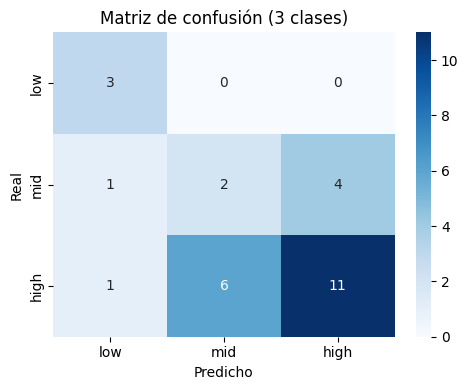

In [31]:

cm = confusion_matrix(y_C_3_test, y_pred_C_3, labels=["low","mid","high"])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["low","mid","high"],
            yticklabels=["low","mid","high"])
plt.xlabel("Predicho"); plt.ylabel("Real")
plt.title("Matriz de confusión (3 clases)")
plt.tight_layout(); plt.show()

F - Conclusion

Clasificación 3 clases: el “mid” cuesta

El informe muestra F1-macro ≈ 0.56 y confusión fuerte hacia high. Es típico con clases desbalanceadas.




4.2 Clasificacion binaria - Low,High

A- Conjunto de modelado y preprocesamiento

In [32]:

y_C_2 = df["Rate_your_academic_stress_index"].astype(float)

# Regla típica en 1–5: alto = 4–5, bajo = 1–3
y_C_2 = np.where(y_C_2 >= 4, "high", "low")
print("Distribución:", pd.Series(y_C_2).value_counts())

X_C_2 = df.drop(columns=["Rate_your_academic_stress_index"])
X_C_2 = pd.get_dummies(X_C_2, drop_first=True)

X_C_2_train, X_C_2_test, y_C_2_train, y_C_2_test = train_test_split(
    X_C_2, y_C_2, test_size=0.2, random_state=42, stratify=y_C_2
)

Distribución: high    89
low     51
Name: count, dtype: int64


B - Pipeline y Gridsearch

In [33]:

pipe_C_2 = Pipeline([
    ("scaler", MinMaxScaler()),
    ("clf", LogisticRegression(random_state=42,max_iter=1000))
])

param_grid_C_2 = [
    {   # Logistic Regression
        "clf": [LogisticRegression(random_state=42, max_iter=1000)],
        "clf__C": [0.1, 1, 10],
        "clf__class_weight": [None, "balanced"],
        "clf__solver": ["lbfgs"]
    },
    {   # Random Forest
        "clf": [RandomForestClassifier(random_state=42, n_jobs=-1)],
        "clf__n_estimators": [300, 600],
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_leaf": [1, 3, 5],
        "clf__max_features": ["sqrt", "log2", 0.8],
        "clf__class_weight": [None, "balanced"]
    }
]

cv_C_2 = KFold(n_splits=5, shuffle=True, random_state=42)

gs_C_2 = GridSearchCV(
    pipe_C_2, param_grid_C_2, cv=cv_C_2,
    scoring="f1",  # binario → F1 de la clase positiva (se elige alfabéticamente)
    n_jobs=-1, refit=True, verbose=0
)
gs_C_2.fit(X_C_2_train, y_C_2_train)

print("Mejor modelo:", gs_C_2.best_estimator_.named_steps["clf"].__class__.__name__)
print("Mejores params:", gs_C_2.best_params_)


Mejor modelo: LogisticRegression
Mejores params: {'clf': LogisticRegression(max_iter=1000, random_state=42), 'clf__C': 0.1, 'clf__class_weight': None, 'clf__solver': 'lbfgs'}


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


C- Evaluacion en test

In [34]:

best = gs_C_2.best_estimator_
y_pred_C_2 = best.predict(X_C_2_test)
y_prob = best.predict_proba(X_C_2_test)[:, list(best.classes_).index("high")]  # prob de 'high'

acc_C_2  = accuracy_score(y_C_2_test, y_pred_C_2)
prec_C_2, rec_C_2, f1_C_2, _ = precision_recall_fscore_support(y_C_2_test, y_pred_C_2, average="binary", pos_label="high")
auc_C_2  = roc_auc_score((y_C_2_test=="high").astype(int), y_prob)

print(f"\nTest → Acc: {acc_C_2:.3f} | Prec: {prec_C_2:.3f} | Rec: {rec_C_2:.3f} | F1: {f1_C_2:.3f} | ROC-AUC: {auc_C_2:.3f}")
print("\n" + classification_report(y_C_2_test, y_pred_C_2, digits=3))


Test → Acc: 0.643 | Prec: 0.654 | Rec: 0.944 | F1: 0.773 | ROC-AUC: 0.731

              precision    recall  f1-score   support

        high      0.654     0.944     0.773        18
         low      0.500     0.100     0.167        10

    accuracy                          0.643        28
   macro avg      0.577     0.522     0.470        28
weighted avg      0.599     0.643     0.556        28



D - Matriz de confusion

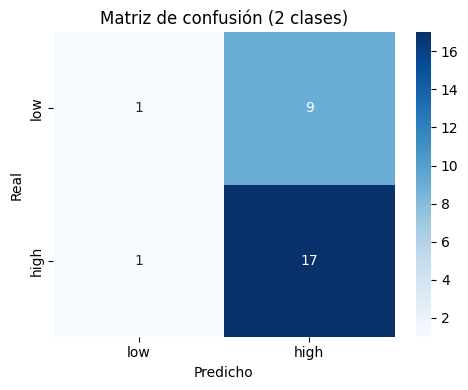

In [35]:

cm = confusion_matrix(y_C_2_test, y_pred_C_2, labels=["low","high"])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["low","high"],
            yticklabels=["low","high"])
plt.xlabel("Predicho"); plt.ylabel("Real")
plt.title("Matriz de confusión (2 clases)")
plt.tight_layout(); plt.show()

E - Conclusion parcial  

Buen recall, baja precisión en “low”

TAcc 0.64 | F1(high) 0.77 | AUC 0.73 pero la clase low queda débil. Se procede a ajustar el umbral de decisión para equilibrar precision/recall

F - Ajuste de umbral

Mejor umbral por F1(low): t = 0.400 | F1(low) = 0.741 | Precision(low) = 0.588 | Recall(low) = 1.000
Umbral con Recall(low)≥0.80: t=0.540 | Prec(low)=0.615 | Rec(low)=0.800 | F1(low)=0.696

[Umbral estándar 0.5]  t=0.500
Precision(low)=0.562 | Recall(low)=0.900 | F1(low)=0.692 | AUC(low)=0.803
              precision    recall  f1-score   support

         low       0.92      0.61      0.73        18
        high       0.56      0.90      0.69        10

    accuracy                           0.71        28
   macro avg       0.74      0.76      0.71        28
weighted avg       0.79      0.71      0.72        28



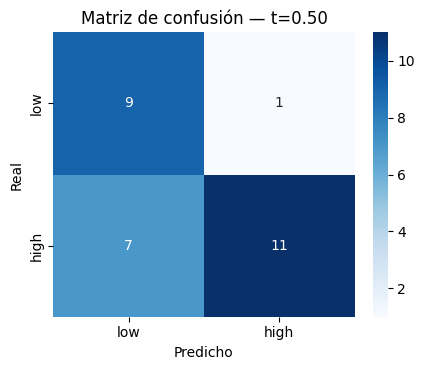


[Umbral óptimo por F1(low)]  t=0.400
Precision(low)=0.588 | Recall(low)=1.000 | F1(low)=0.741 | AUC(low)=0.803
              precision    recall  f1-score   support

         low       1.00      0.61      0.76        18
        high       0.59      1.00      0.74        10

    accuracy                           0.75        28
   macro avg       0.79      0.81      0.75        28
weighted avg       0.85      0.75      0.75        28



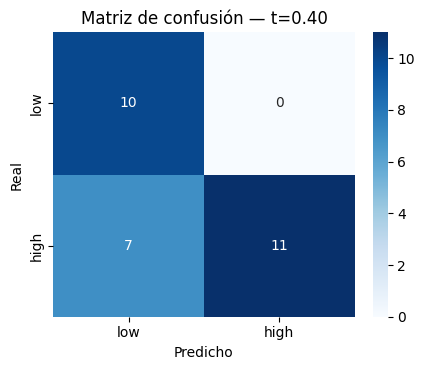


[Umbral con Recall(low) ≥ 0.80]  t=0.540
Precision(low)=0.615 | Recall(low)=0.800 | F1(low)=0.696 | AUC(low)=0.803
              precision    recall  f1-score   support

         low       0.87      0.72      0.79        18
        high       0.62      0.80      0.70        10

    accuracy                           0.75        28
   macro avg       0.74      0.76      0.74        28
weighted avg       0.78      0.75      0.75        28



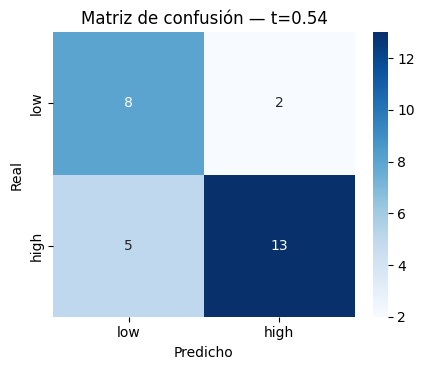

In [47]:

pipe_C_2_b = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", LogisticRegression(max_iter=2000,
                               class_weight="balanced",
                               random_state=42))
])

pipe_C_2_b.fit(X_C_2_train, y_C_2_train)

# 2) Probabilidades para la clase 'low'
classes = pipe_C_2_b.named_steps["clf"].classes_      # orden de clases
idx_low = np.where(classes == "low")[0][0]
proba_low_C_2 = pipe_C_2_b.predict_proba(X_C_2_test)[:, idx_low]

# 3) Barrido de umbrales y métricas por umbral
ths = np.linspace(0, 1, 201)
prec_low, rec_low, f1_low = [], [], []

for t in ths:
    y_pred_t = np.where(proba_low_C_2 >= t, "low", "high")
    prec_low.append(precision_score(y_C_2_test, y_pred_t, pos_label="low", zero_division=0))
    rec_low.append(recall_score(y_C_2_test, y_pred_t, pos_label="low"))
    f1_low.append(f1_score(y_C_2_test, y_pred_t, pos_label="low"))

prec_low = np.array(prec_low)
rec_low  = np.array(rec_low)
f1_low   = np.array(f1_low)

# 4A) Mejor umbral por F1 de la clase 'low'
best_idx = np.argmax(f1_low)
best_t_F1 = ths[best_idx]
print(f"Mejor umbral por F1(low): t = {best_t_F1:.3f} | F1(low) = {f1_low[best_idx]:.3f} | "
      f"Precision(low) = {prec_low[best_idx]:.3f} | Recall(low) = {rec_low[best_idx]:.3f}")

# 4B) Mejor umbral sujeto a recall mínimo
recall_objetivo = 0.80
mask = rec_low >= recall_objetivo
if mask.any():
    idx_recall = np.argmax(prec_low[mask])          # el de mayor precisión cumpliendo recall
    best_t_recall = ths[mask][idx_recall]
    print(f"Umbral con Recall(low)≥{recall_objetivo:.2f}: t={best_t_recall:.3f} | "
          f"Prec(low)={prec_low[mask][idx_recall]:.3f} | "
          f"Rec(low)={rec_low[mask][idx_recall]:.3f} | "
          f"F1(low)={f1_low[mask][idx_recall]:.3f}")
else:
    best_t_recall = None
    print(f"No hay umbral que alcance Recall(low)≥{recall_objetivo:.2f} en este test.")

# 5) Comparativa: umbral 0.5 vs umbral óptimo por F1(low)
def eval_umbral(t, titulo=""):
    y_pred = np.where(proba_low_C_2 >= t, "low", "high")
    auc_low = roc_auc_score((y_C_2_test == "low").astype(int), proba_low_C_2)
    print(f"\n[{titulo}]  t={t:.3f}")
    print(f"Precision(low)={precision_score(y_C_2_test, y_pred, pos_label='low', zero_division=0):.3f} | "
          f"Recall(low)={recall_score(y_C_2_test, y_pred, pos_label='low'):.3f} | "
          f"F1(low)={f1_score(y_C_2_test, y_pred, pos_label='low'):.3f} | "
          f"AUC(low)={auc_low:.3f}")
    print(classification_report(y_C_2_test, y_pred, target_names=["low", "high"]))
    cm = confusion_matrix(y_C_2_test, y_pred, labels=["low","high"])
    plt.figure(figsize=(4.5,3.8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["low","high"], yticklabels=["low","high"])
    plt.title(f"Matriz de confusión — t={t:.2f}")
    plt.xlabel("Predicho"); plt.ylabel("Real"); plt.tight_layout(); plt.show()

# Evaluación con t=0.5
eval_umbral(0.5, "Umbral estándar 0.5")

# Evaluación con umbral óptimo por F1(low)
eval_umbral(best_t_F1, "Umbral óptimo por F1(low)")

# Usar el umbral que cumple recall objetivo:
if best_t_recall is not None:
    eval_umbral(best_t_recall, f"Umbral con Recall(low) ≥ {recall_objetivo:.2f}")


G - Conclusion final

Se redefinió el target en dos grupos (1–3 = low, 4–5 = high).

La Logistic Regression dio Acc ≈ 0.64 y F1(high) ≈ 0.77 pero el principal problema es que tiende a capturar todo como high.

El modelo fue especialmente fuerte en detectar casos “high” (recall ≈ 0.94), aunque más débil en “low”.

Con ajuste de umbral (t = 0.535), se logró aumentar presicion y recall en "high" manteniendo buenos valores en "low",

La  prioridad es detectar todos los casos de riesgo (no perder positivos)

En resumen: la clasificación binaria fue más estable y práctica para fines aplicados (detectar estudiantes en alto riesgo de estrés).



# 5 - Clustering

A - Conjunto de datos y pre procesamiento

In [38]:
num_cols = [
    "Peer_pressure",
    "Academic_pressure_from_your_home",
    "What_would_you_rate_the_academic_competition_in_your_student_life",
]

cat_cols = [
    "Study_Environment",
    "Your_Academic_Stage",
    "Do_you_have_any_bad_habits_like_smoking,_drinking_on_a_daily_basis?",              # valores: No / prefer not to say / Yes
]

stress_col = "Rate_your_academic_stress_index"  # solo para perfilar

X = df[num_cols + cat_cols].copy()

In [39]:

pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("sc",  StandardScaler())]), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("oh",  OneHotEncoder(handle_unknown="ignore"))]), cat_cols)
])

B - Kmeans con Elbow + Silhouette

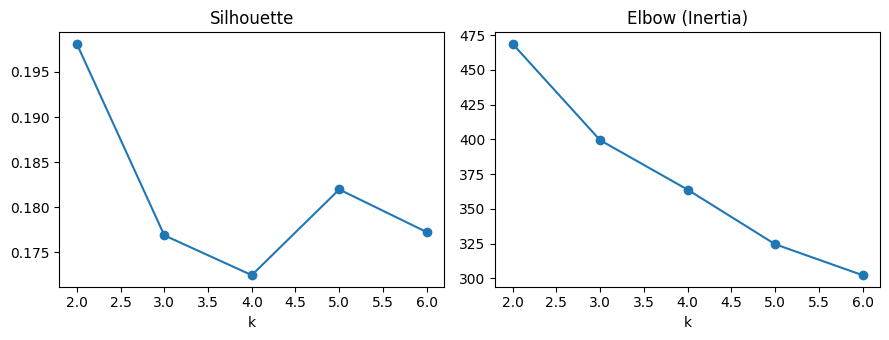

K seleccionado: 2


In [40]:

Ks = range(2, 7)
sil, inertia = [], []

for k in Ks:
    pipe = Pipeline([("pre", pre), ("km", KMeans(n_clusters=k, n_init=20, random_state=42))])
    labels = pipe.fit_predict(X)
    Z = pipe.named_steps["pre"].transform(X)
    Z = Z.toarray() if hasattr(Z, "toarray") else Z
    sil.append(silhouette_score(Z, labels))
    inertia.append(pipe.named_steps["km"].inertia_)

fig, ax = plt.subplots(1,2, figsize=(9,3.5))
ax[0].plot(Ks, sil, "o-"); ax[0].set_title("Silhouette"); ax[0].set_xlabel("k")
ax[1].plot(Ks, inertia, "o-"); ax[1].set_title("Elbow (Inertia)"); ax[1].set_xlabel("k")
plt.tight_layout(); plt.show()

best_k = Ks[int(np.argmax(sil))]
print("K seleccionado:", best_k)

C- Entrenar modelo

In [41]:

k = 2
pipe_k2 = Pipeline([
    ("pre", pre),                                    # tu preprocesador (imputar, escalar, one-hot)
    ("km",  KMeans(n_clusters=k, n_init=20, random_state=42))
])

df["cluster2"] = pipe_k2.fit_predict(X)
df["cluster2"].value_counts().sort_index()

,count
cluster2,
0,86
1,54


D - Perfilado de clusters

In [42]:

profile_num = df.groupby("cluster2")[num_cols].mean().round(2)
display(profile_num)

for c in cat_cols:
    print(f"\n{c}")
    display(
        (df.groupby("cluster2")[c]
           .value_counts(normalize=True)
           .mul(100).rename("pct").round(1))
    )

,Peer_pressure,Academic_pressure_from_your_home,What_would_you_rate_the_academic_competition_in_your_student_life
cluster2,,,
0,2.47,2.59,3.3
1,4.04,4.11,3.8



Study_Environment


cluster2  Study_Environment
0         Peaceful             61.6
          Noisy                20.9
          disrupted            17.4
1         disrupted            42.6
          Peaceful             31.5
          Noisy                25.9
Name: pct, dtype: float64


Your_Academic_Stage


cluster2  Your_Academic_Stage
0         undergraduate          73.3
          high school            18.6
          post-graduate           8.1
1         undergraduate          68.5
          high school            24.1
          post-graduate           7.4
Name: pct, dtype: float64


Do_you_have_any_bad_habits_like_smoking,_drinking_on_a_daily_basis?


cluster2  Do_you_have_any_bad_habits_like_smoking,_drinking_on_a_daily_basis?
0         No                                                                     91.9
          prefer not to say                                                       4.7
          Yes                                                                     3.5
1         No                                                                     81.5
          Yes                                                                    13.0
          prefer not to say                                                       5.6
Name: pct, dtype: float64

In [43]:
stress_col = "Rate_your_academic_stress_index"
display(df.groupby("cluster2")[stress_col].agg(["mean","median","count"]).round(2))



,mean,median,count
cluster2,,,
0,3.35,3.0,86
1,4.31,4.0,54


D - Graficas

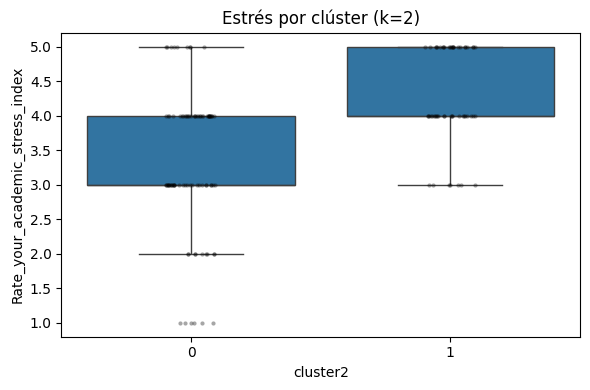

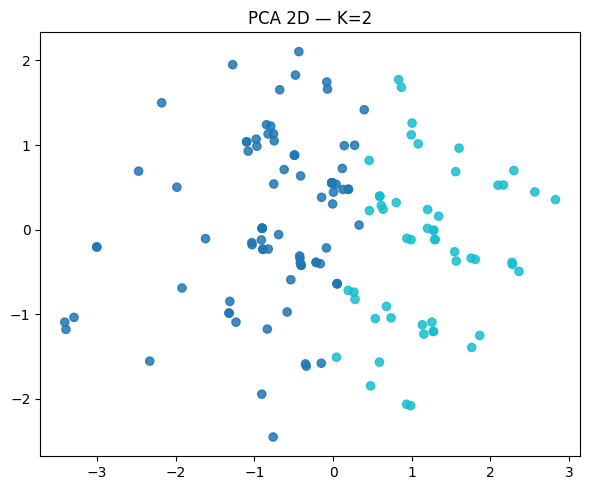

In [44]:
# Boxplot de estrés por clúster
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="cluster2", y=stress_col, showfliers=False)
sns.stripplot(data=df, x="cluster2", y=stress_col, color="k", alpha=0.35, size=3)
plt.title("Estrés por clúster (k=2)"); plt.tight_layout(); plt.show()

# PCA 2D para visualizar
from sklearn.decomposition import PCA
Z = pipe_k2.named_steps["pre"].transform(X)
Z = Z.toarray() if hasattr(Z, "toarray") else Z
XY = PCA(n_components=2, random_state=42).fit_transform(Z)

plt.figure(figsize=(6,5))
plt.scatter(XY[:,0], XY[:,1], c=df["cluster2"], cmap="tab10", s=35, alpha=0.85)
plt.title("PCA 2D — K=2"); plt.tight_layout(); plt.show()

E - Conclusion parcial

El primer análisis de clustering, realizado sobre los datos preprocesados pero sin reducción de dimensionalidad, mostró que el número óptimo de clústeres era k=2. Este resultado reveló la división más fuerte y evidente en el dataset:

Un grupo de estudiantes con estrés bajo/moderado, en su mayoría con entornos pacíficos y menos presión externa.

Un grupo con estrés alto, caracterizado por mayor presión de pares y familiar, entornos de estudio desfavorables y mayor incidencia de hábitos nocivos.

Esta segmentación inicial permitió identificar dos macro-perfiles claros: estudiantes resilientes y estudiantes vulnerables. Fue un hallazgo útil para entender la estructura básica del fenómeno, aunque todavía general.

F - PCA para optimizar K

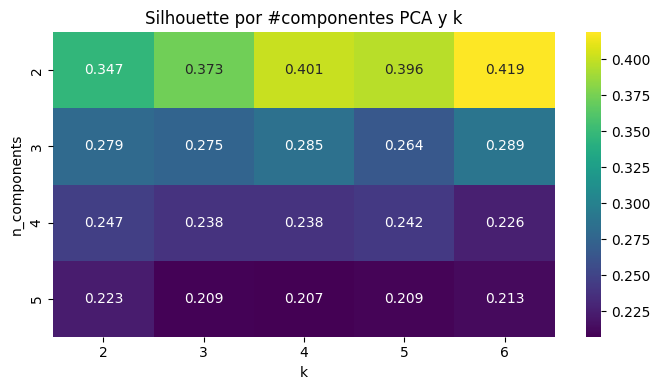

Mejor combinación → n_components=2, k=6, Silhouette=0.419
Silhouette final (mejor combinación): 0.419


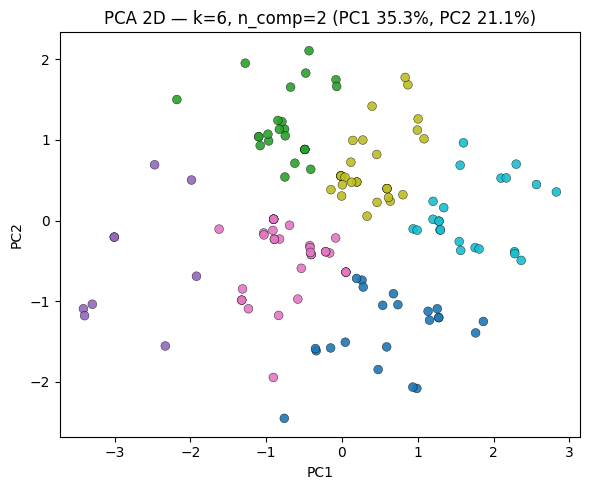

,mean,median,count
cluster_pca,,,
0,4.05,4.0,22
1,3.52,4.0,23
2,1.89,2.0,9
3,3.34,3.0,32
4,4.00,4.0,31
5,4.48,5.0,23


,Peer_pressure,Academic_pressure_from_your_home,What_would_you_rate_the_academic_competition_in_your_student_life
cluster_pca,,,
0,3.73,4.41,2.55
1,2.30,1.91,4.26
2,1.33,1.22,1.78
3,2.72,2.84,2.75
4,3.19,3.16,4.26
5,4.22,4.52,4.30


In [45]:

n_components_grid = [2, 3, 4, 5]
k_grid = [2, 3, 4, 5, 6]

results = []

# Preprocess una sola vez y luego aplico PCA sobre Z
Z_2 = pre.fit_transform(X)
Z_2 = Z.toarray() if hasattr(Z, "toarray") else Z  # PCA necesita denso

for nc in n_components_grid:
    pca = PCA(n_components=nc, random_state=42)
    Zp = pca.fit_transform(Z_2)

    for k in k_grid:
        km = KMeans(n_clusters=k, n_init=20, random_state=42)
        labels = km.fit_predict(Zp)
        sil = silhouette_score(Zp, labels)
        results.append({"n_components": nc, "k": k, "silhouette": sil, "inertia": km.inertia_})

res = pd.DataFrame(results)

# --- Mapa de calor de Silhouette (más alto = mejor) ---
pt = res.pivot(index="n_components", columns="k", values="silhouette")
plt.figure(figsize=(7, 4))
sns.heatmap(pt, annot=True, fmt=".3f", cmap="viridis")
plt.title("Silhouette por #componentes PCA y k")
plt.ylabel("n_components"); plt.xlabel("k"); plt.tight_layout(); plt.show()

best = res.loc[res["silhouette"].idxmax()]
best_nc, best_k = int(best["n_components"]), int(best["k"])
print(f"Mejor combinación → n_components={best_nc}, k={best_k}, Silhouette={best['silhouette']:.3f}")

# --- Entrenar pipeline final con la mejor combinación ---
pipe_final = Pipeline([
    ("pre", pre),
    ("pca", PCA(n_components=best_nc, random_state=42)),
    ("km",  KMeans(n_clusters=best_k, n_init=20, random_state=42))
])

clusters = pipe_final.fit_predict(X)
df["cluster_pca"] = clusters

# Silhouette final calculado en el espacio PCA
Z_final = pipe_final.named_steps["pre"].transform(X)
Z_final = Z_final.toarray() if hasattr(Z_final, "toarray") else Z_final
Zp_final = pipe_final.named_steps["pca"].transform(Z_final)
sil_final = silhouette_score(Zp_final, clusters)
print(f"Silhouette final (mejor combinación): {sil_final:.3f}")

# --- Visualización 2D en PCA (siempre toma PC1 y PC2) ---
XY = Zp_final if Zp_final.shape[1] >= 2 else np.c_[Zp_final, np.zeros(len(Zp_final))]
plt.figure(figsize=(6,5))
plt.scatter(XY[:,0], XY[:,1], c=clusters, cmap="tab10", s=40, alpha=0.9, edgecolor="k", linewidth=0.3)
evr = pipe_final.named_steps["pca"].explained_variance_ratio_
ttl = f"PCA 2D — k={best_k}, n_comp={best_nc} (PC1 {evr[0]*100:.1f}%, PC2 {evr[1]*100:.1f}%)"
plt.title(ttl)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.tight_layout(); plt.show()

# --- Perfil rápido por clúster  ---

try:
    stress_col = "Rate_your_academic_stress_index"
    display(df.groupby("cluster_pca")[stress_col].agg(["mean","median","count"]).round(2))
except Exception:
    pass

try:
    profile_num = df.groupby("cluster_pca")[num_cols].mean().round(2)
    display(profile_num)
except Exception:
    pass

G - Conclusion final

En una segunda etapa, al aplicar PCA con 2 componentes principales para condensar la variabilidad más relevante y reducir ruido, el análisis de calidad de clústeres indicó que el óptimo se alcanzaba con k=6.

Este ajuste permitió refinar la visión inicial: en lugar de solo dos macro-grupos, emergieron seis perfiles diferenciados de estudiantes, que reflejan matices en la experiencia académica.

👉 Esta segunda fase enriqueció el análisis, pasando de una visión macro (resilientes vs. vulnerables) a una visión micro (segmentación en 6 perfiles). Esto hace que las conclusiones sean más aplicables en la práctica, ya que permiten diseñar intervenciones específicas para cada tipo de estudiante.

# 6 - Conclusion

El proyecto mostró que el estrés académico es multifactorial y que, aunque los modelos predictivos ofrecen una capacidad moderada de anticipar niveles de estrés, el verdadero valor está en la identificación de patrones y perfiles. La combinación de enfoques supervisados y no supervisados permitió no solo predecir, sino también explicar y segmentar.

En la práctica, esto implica que las instituciones educativas podrían:

Implementar sistemas de alerta temprana para detectar estudiantes con alto riesgo de estrés.

Diseñar estrategias diferenciadas de apoyo, basadas en los perfiles encontrados (ej.: talleres para manejar presión social, programas para mejorar el entorno de estudio, espacios de acompañamiento emocional).

En definitiva, el proyecto no solo cumplió con el objetivo técnico de aplicar modelos de machine learning, sino que también generó insumos valiosos para la acción, mostrando cómo la ciencia de datos puede apoyar directamente al bienestar estudiantil.

# 7 - Anexo clasificador binario

In [48]:
import gradio as gr
import joblib


# guardar el pipeline completo
joblib.dump(pipe_C_2_b, "pipe_C_2_b.pkl")

# guardar las columnas finales de entrenamiento (tras get_dummies)
joblib.dump(list(X_C_2.columns), "X_C_2_cols.pkl")

# --- cargar modelo y columnas con los nombres de tu proyecto ---
clf = joblib.load("pipe_C_2_b.pkl")
cols = joblib.load("X_C_2_cols.pkl")
THRESH = 0.535

def clasificar(stage, peer, home, env, coping, habits, comp):
    # 1. armar fila con los nombres originales del dataset
    row = pd.DataFrame([{
        "Your_Academic_Stage": stage,
        "Peer_pressure": int(peer),
        "Academic_pressure_from_your_home": int(home),
        "Study_Environment": env,
        "What_coping_strategy_you_use_as_a_student?": coping,
        "Do_you_have_any_bad_habits_like_smoking,_drinking_on_a_daily_basis?": habits,
        "What_would_you_rate_the_academic_competition_in_your_student_life": int(comp),
    }])

    # 2. aplicar get_dummies y reindexar columnas
    X = pd.get_dummies(row, drop_first=True).reindex(columns=cols, fill_value=0)

    # 3. calcular probabilidad de la clase "high"
    idx_high = list(clf.classes_).index("high")
    proba_high = clf.predict_proba(X)[:, idx_high][0]

    # 4. aplicar umbral elegido
    pred = "high" if proba_high >= THRESH else "low"

    return f"Predicción: {pred.upper()}  |  Prob(high)={proba_high:.3f}  |  Umbral={THRESH}"

# --- interfaz ---
demo = gr.Interface(
    fn=clasificar,
    inputs=[
        gr.Dropdown(["high school","undergraduate","post-graduate"], label="Your_Academic_Stage"),
        gr.Slider(1,5,step=1,label="Peer_pressure"),
        gr.Slider(1,5,step=1,label="Academic_pressure_from_your_home"),
        gr.Dropdown(["Peaceful","Noisy","disrupted"], label="Study_Environment"),
        gr.Dropdown([
            "Analyze the situation and handle it with intellect",
            "Social support (friends, family)",
            "Emotional breakdown (crying a lot)"
        ], label="What_coping_strategy_you_use_as_a_student?"),
        gr.Dropdown(["No","Yes","prefer not to say"], label="Do_you_have_any_bad_habits_like_smoking,_drinking_on_a_daily_basis?"),
        gr.Slider(1,5,step=1,label="What_would_you_rate_the_academic_competition_in_your_student_life"),
    ],
    outputs="text",
    title="Clasificador Binario de Estrés Académico (LOW vs HIGH)"
)

demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://da2758bd7e52e60a05.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
